In [135]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import streamlit as st
from GHEtool import Borefield, FluidData, GroundData, PipeData
import pygfunction as gt

Input-variabler:

In [136]:
DEKGRAD = 0.90
VIRKGRAD = 0.80     #Virkningsgrad til kompressor i varmepumpen
LEDNINGSEVNE = 3.5  #Ground thermal conductivity (W/m.K) ???
UFORST_TEMP = 7.5
MIN_BRONNTEMP = 5


MAKS_TURTEMP = 45
MIN_TURTEMP = 35
COP_OGSAA_AVH_AV_TURTEMP = True  # True eller false                  True tar ~5 min,  False tar ~1 min


UTETEMP_FOR_MAKS_TURTEMP = -15
UTETEMP_FOR_MIN_TURTEMP = 15


ANTALL_AAR = 25
COP = 3.5                       # Resultat uavhengig av denne
DYBDE_STARTGJETT = 250          # Resultat uavhengig av denne

Funksjoner:

In [137]:
# Funksjon for Lineær interpolering:
def lin_interp(x,x1,x2,y1,y2):
    y = y1+(x-x1)*(y2-y1)/(x2-x1)
    return y

def bronnlast_fra_COP(grunnlast,cop,virkgrad):
    ellast = grunnlast/cop*virkgrad
    bronnlast = grunnlast-ellast

    return bronnlast


def GHE_tool_bronndybde(bronnlast,min_bronntemp,dybde_startgjett,ledningsevne,uforst_temp):
    data = GroundData(ledningsevne, uforst_temp, 0.10, 2.4 * 10**6)
    borefield_gt = gt.boreholes.rectangle_field(N_1=1, N_2=1, B_1=6, B_2=6, H=dybde_startgjett, D = 10, r_b = 0.10)

    borefield = Borefield(simulation_period=20)
    borefield.set_ground_parameters(data)
    borefield.set_borefield(borefield_gt)        
    borefield.set_hourly_heating_load(bronnlast)

    borefield.set_max_ground_temperature(16)   # maximum temperature   Utgjør ingen forskjell å endre på denne.
    borefield.set_min_ground_temperature(min_bronntemp)    # minimum temperature
    dybde = borefield.size(dybde_startgjett, L3_sizing=True)

    print('Nødvendig brønndybde (GHE-tool):',dybde,'m.')
    return dybde


def kjor_pygf(bronnlast_data,bronndybde,antall_aar,ledningsevne,uforst_temp):
    # Beregning av brønntemperatur vha. Magnes pygfunction-kode:
    import pygfunction_Magne
    pygf = pygfunction_Magne.Simulation()                           # For at dette skal fungere, må det velges "Rektangulær" i pygfunction-filen
    pygf.select_borehole_field(1)               #Antall brønner 
    pygf.YEARS = antall_aar
    pygf.U_PIPE = "Single"  # Choose between "Single" and "Double"
    pygf.R_B = 0.114  # Radius (m)
    pygf.R_OUT = 0.020  # Pipe outer radius (m)
    pygf.R_IN = 0.0176  # Pipe inner radius (m)
    pygf.D_S = 0.067/2  # Shank spacing (m)
    pygf.EPSILON = 1.0e-6  # Pipe roughness (m)
    pygf.ALPHA = 1.39e-6  # Ground thermal diffusivity (m2/s)
    pygf.K_S = ledningsevne  # Ground thermal conductivity (W/m.K)            
    pygf.T_G = uforst_temp  # Undisturbed ground temperature (degrees)   
    pygf.K_G = 2  # Grout thermal conductivity (W/m.K)
    pygf.K_P = 0.42  # Pipe thermal conductivity (W/m.K)
    pygf.H = bronndybde  # Borehole depth (m)
    pygf.B = 15  # Distance between boreholes (m)
    pygf.D = 10  # Borehole buried depth
    pygf.FLOW_RATE = 0.5  # Flow rate (kg/s)
    pygf.FLUID_NAME = "MPG"  # The fluid is propylene-glycol 
    pygf.FLUID_DEGREES = 5  # at 20 degC
    pygf.BOUNDARY_CONDITION = 'MIFT'
    pygf.run_simulation(np.array(bronnlast_data)) #Grunnlast i enhet kW

    nybronntemp = pygf.tf_out
    returtemp = pygf.tf_in
    return nybronntemp,returtemp


def bestem_turtemp(utetemp,utetemp_for_maks_turtemp,utetemp_for_min_turtemp,maks_turtemp,min_turtemp):
    turtemp = np.zeros(len(utetemp))
    for i in range(0,len(utetemp)):
        if utetemp[i]<utetemp_for_maks_turtemp:
            turtemp[i] = maks_turtemp
        elif utetemp[i]>utetemp_for_min_turtemp:
            turtemp[i] = min_turtemp
        else:
            #Lineær interpolering:
            turtemp[i] = lin_interp(utetemp[i],utetemp_for_maks_turtemp,utetemp_for_min_turtemp,maks_turtemp,min_turtemp)
    return turtemp

def finn_ny_COP(bronntemp_vektor,stigtall35,konstledd35,stigtall45,konstledd45,turtemp,maks_turtemp,min_turtemp):
    # COP som funksjon av turtemp (basert på COP som funksjon av brønntemp)
    nyCOP = np.zeros(len(turtemp))
    for i in range(0,len(turtemp)):
        if turtemp[i] == maks_turtemp:
            nyCOP[i] = stigtall45*bronntemp_vektor[i]+konstledd45
        elif turtemp[i] == min_turtemp:
            nyCOP[i] = stigtall35*bronntemp_vektor[i]+konstledd35
        else:
            stigtall_interp = lin_interp(turtemp[i],min_turtemp,maks_turtemp,stigtall35,stigtall45)
            konstledd_interp = lin_interp(turtemp[i],min_turtemp,maks_turtemp,konstledd35,konstledd45)
            COP_interp = stigtall_interp*bronntemp_vektor[i]+konstledd_interp
            nyCOP[i] = COP_interp
        nyCOP=np.array(nyCOP)

        COP=nyCOP
    return COP

def finn_ny_COP_konst_turtemp(bronntemp_vektor,stigtall,konstledd):
    nyCOP = stigtall * bronntemp_vektor + konstledd
    return nyCOP


Program:

In [138]:
stigtall40 = 0.07415827970667467
konstledd40 = 3.8186265651501543

In [139]:
# COP-Verdier fra datablad
databladtemp35 = np.array([-5,-2,0,2,5,10,15])
COP_data35 = np.array([3.68, 4.03, 4.23, 4.41, 4.56, 5.04, 5.42])
databladtemp45 = np.array([-2,0,2,5,10,15])
COP_data45 = np.array([3.3, 3.47, 3.61, 3.77, 4.11, 4.4])

#Kjører lineær regresjon på COP-verdier fra datablad:
from lin_reg import *
lin_COP_data35 = lin_reg(databladtemp35,COP_data35)
lin_COP_data45 = lin_reg(databladtemp45,COP_data45)

# Parametre i uttrykket for den lineære regresjonen av COP fra datablad
stigtall35 = (lin_COP_data35[-1]-lin_COP_data35[0])/(databladtemp35[-1]-databladtemp35[0])
konstledd35 = lin_COP_data35[-1]-stigtall35*databladtemp35[-1]

stigtall45 = (lin_COP_data45[-1]-lin_COP_data45[0])/(databladtemp45[-1]-databladtemp45[0])
konstledd45 = lin_COP_data45[-1]-stigtall45*databladtemp45[-1]

Funksjonsuttrykket blir y= [0.08451848] x + [4.17957685]
Funksjonsuttrykket blir y= [0.06379808] x + [3.45767628]


In [140]:
dato = []
varmelast = []
utetemp =[]
  
with open('timedata2.csv','r') as csvfile:
    lines = csv.reader(csvfile, delimiter='\t')
    for row in lines:
        dato.append(row[0])
        utetemp.append(float(row[4]))
        varmelast.append(float(row[7]))

In [141]:
grunnlast = 1*varmelast
spisslast = 1*varmelast

maks = np.max(varmelast)
mini = np.min(varmelast)

for kap in np.arange(0.8*maks,mini,-0.01*maks):  #Sjekker fra 80% av makslast og nedover med steglengde 1% av denne.
    for i in range(0, len(grunnlast)):
        if grunnlast[i]>=kap:
            grunnlast[i]=kap
        else:
            grunnlast[i]=grunnlast[i]
        
    for j in range(0,len(spisslast)):
            if grunnlast[j]>=kap:
                spisslast[j]=varmelast[j]-kap
            else:
                spisslast[j]=0

    if np.sum(grunnlast)/(np.sum(varmelast))<DEKGRAD:
        break

grunnlast = np.array(grunnlast)
GRUNNLAST = np.hstack(ANTALL_AAR*[grunnlast])

In [142]:
DYBDE = DYBDE_STARTGJETT
turtemp = bestem_turtemp(utetemp,UTETEMP_FOR_MAKS_TURTEMP,UTETEMP_FOR_MIN_TURTEMP,MAKS_TURTEMP,MIN_TURTEMP)
TURTEMP = np.hstack(ANTALL_AAR*[turtemp])

COP = np.array([COP]*8760*ANTALL_AAR)

for k in range(0,10):

    BRONNLAST = bronnlast_fra_COP(GRUNNLAST,COP,VIRKGRAD)
    
    dybde_GHE = GHE_tool_bronndybde(BRONNLAST,MIN_BRONNTEMP,DYBDE,LEDNINGSEVNE,UFORST_TEMP)
    
    [bronntemp,returtemp] = kjor_pygf(BRONNLAST,dybde_GHE,ANTALL_AAR,LEDNINGSEVNE,UFORST_TEMP)
    print(len(bronntemp))

    if COP_OGSAA_AVH_AV_TURTEMP == True:
        nyCOP = finn_ny_COP(bronntemp,stigtall35,konstledd35,stigtall45,konstledd45,TURTEMP,MAKS_TURTEMP,MIN_TURTEMP)
    else:
        nyCOP = finn_ny_COP_konst_turtemp(bronntemp,stigtall40,konstledd40)
    
    if np.mean(np.abs(nyCOP-COP))<0.001: 
        COP = nyCOP
        break
    else:
        COP = nyCOP


snittCOP = round(np.mean(COP),3)
print('')
print('---------------------------------------------')
print('Brønndybde: \t \t',round(dybde_GHE,3),'m')
print('Minste Brønntemp: \t',round(np.min(bronntemp),3),'degC')
print('Gjennomsnittlig COP: \t',snittCOP)
print('Laveste COP-verdi: \t',round(np.min(COP),3))
print('')
print('Brønnlast gitt denne COP:')
print(BRONNLAST)
    

Nødvendig brønndybde (GHE-tool): 395.41322282085906 m.
219000
Nødvendig brønndybde (GHE-tool): 417.72945658790326 m.
219000


Diagrammer:

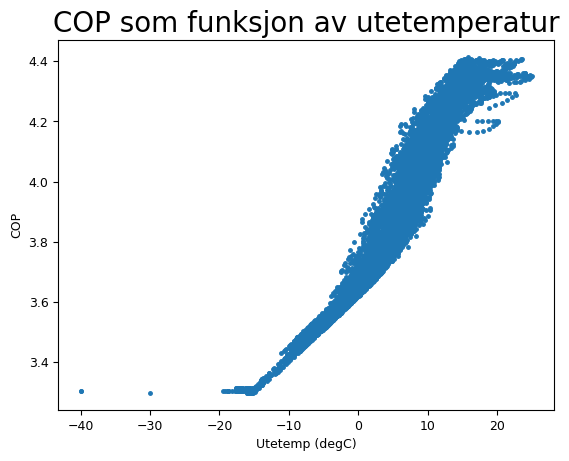

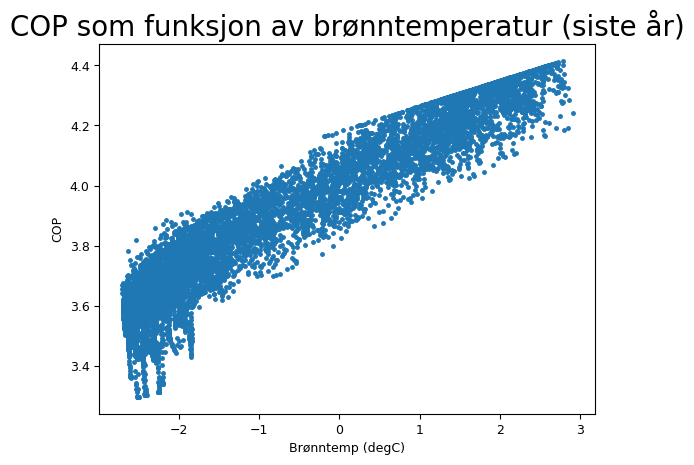

In [ ]:
plt.plot(utetemp,COP[-8760:],'.')
plt.title(('COP som funksjon av utetemperatur'), fontsize = 20)
plt.xlabel('Utetemp (degC)')
plt.ylabel("COP")
#plt.legend(['Returtemperatur til brønn','Brønntemperatur'])
plt.show()

plt.plot(bronntemp[-8760:],COP[-8760:],'.')
plt.title(('COP som funksjon av brønntemperatur (siste år)'), fontsize = 20)
plt.xlabel('Brønntemp (degC)')
plt.ylabel("COP")
#plt.legend(['Returtemperatur til brønn','Brønntemperatur'])
plt.show()

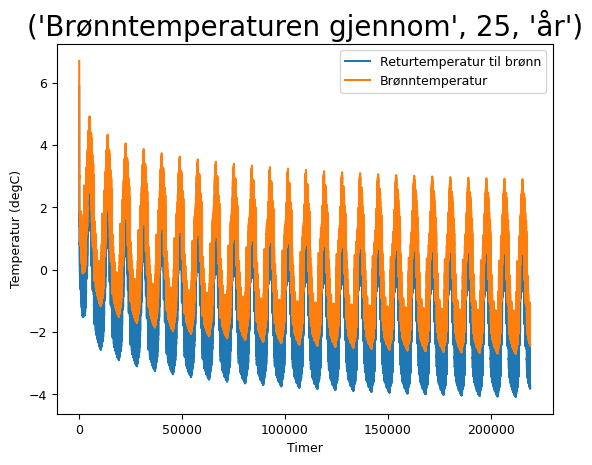

In [ ]:
plt.plot(returtemp)
plt.plot(bronntemp)
plt.title(('Brønntemperaturen gjennom', ANTALL_AAR, 'år'), fontsize = 20)
plt.xlabel('Timer')
plt.ylabel("Temperatur (degC)")
plt.legend(['Returtemperatur til brønn','Brønntemperatur'])
plt.show()

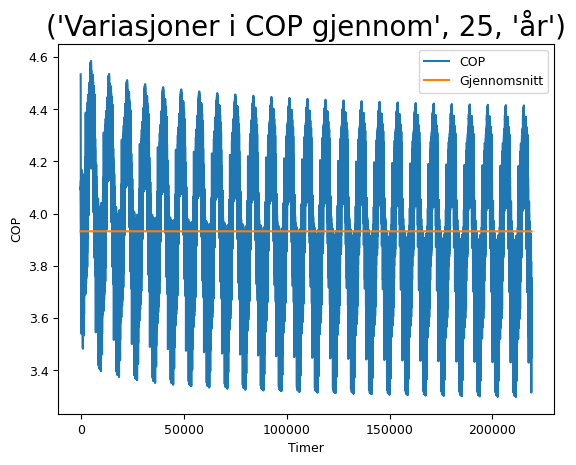

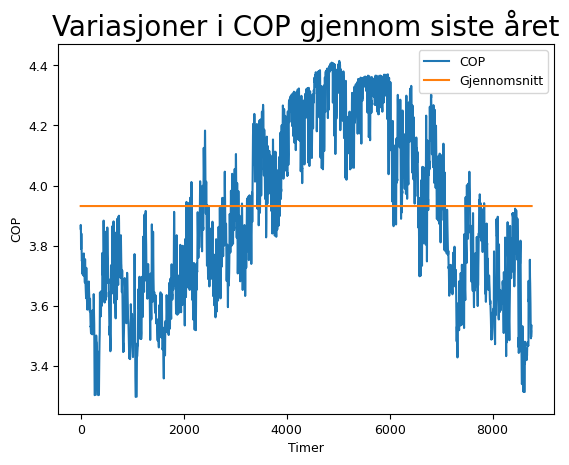

In [ ]:
plt.plot(COP)
plt.plot(np.array([snittCOP]*len(COP)))
plt.title(('Variasjoner i COP gjennom', ANTALL_AAR, 'år'), fontsize = 20)
plt.xlabel('Timer')
plt.ylabel("COP")
plt.legend(['COP','Gjennomsnitt'])
plt.show()

plt.plot(COP[-8760:])
plt.plot(np.array([snittCOP]*8760))
plt.title('Variasjoner i COP gjennom siste året', fontsize = 20)
plt.xlabel('Timer')
plt.ylabel("COP")
plt.legend(['COP','Gjennomsnitt'])
plt.show()

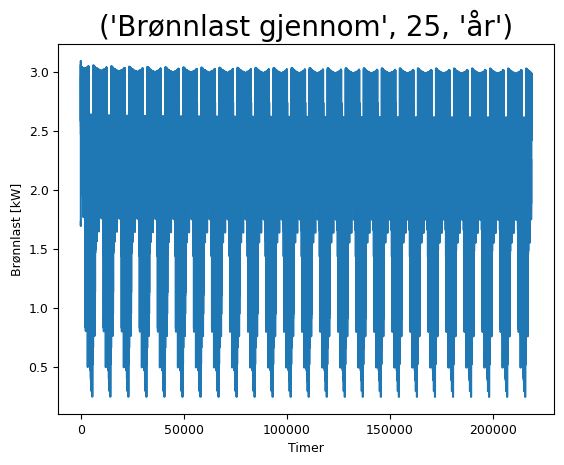

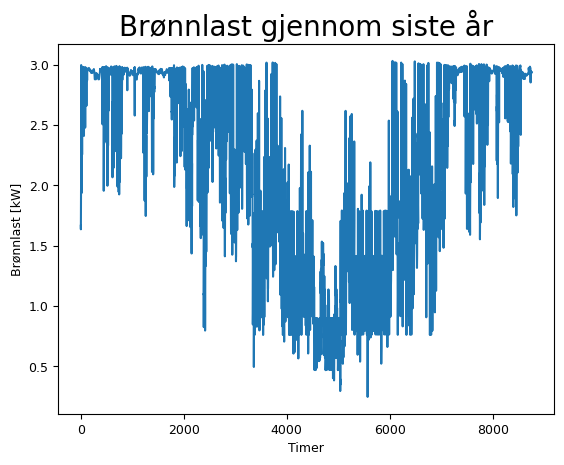

In [ ]:
plt.plot(BRONNLAST)
plt.title(('Brønnlast gjennom', ANTALL_AAR, 'år'), fontsize = 20)
plt.xlabel('Timer')
plt.ylabel("Brønnlast [kW]")
#plt.legend(['COP','Gjennomsnitt'])
plt.show()

plt.plot(BRONNLAST[-8760:])
plt.title(('Brønnlast gjennom siste år'), fontsize = 20)
plt.xlabel('Timer')
plt.ylabel("Brønnlast [kW]")
#plt.legend(['COP','Gjennomsnitt'])
plt.show()